In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
path = "C:\\Users\\leoka\\Documents\\GitHub\\Brasileirao_Dataset"

# Definição do Problema: Mostrar quem são os artilheiros mais decisivos do campeonato

## Passo 1: Atribuir pontuação a gols
Os gols terão pontuações atribuidas de acordo com o mandante da partida e o placar do momento.

In [2]:
df_partidas = pd.read_csv(path+"\\campeonato-brasileiro-full.csv", index_col="ID")
df_partidas.head()

,rodata,data,hora,mandante,visitante,formacao_mandante,formacao_visitante,tecnico_mandante,tecnico_visitante,vencedor,arena,mandante_Placar,visitante_Placar,mandante_Estado,visitante_Estado
ID,,,,,,,,,,,,,,,
1,1,29/03/2003,16:00,Guarani,Vasco,NaN,NaN,NaN,NaN,Guarani,Brinco de Ouro,4,2,SP,RJ
2,1,29/03/2003,16:00,Athletico-PR,Gremio,NaN,NaN,NaN,NaN,Athletico-PR,Arena da Baixada,2,0,PR,RS
3,1,30/03/2003,16:00,Flamengo,Coritiba,NaN,NaN,NaN,NaN,-,Maracanã,1,1,RJ,PR
4,1,30/03/2003,16:00,Goias,Paysandu,NaN,NaN,NaN,NaN,-,Serra Dourada,2,2,GO,PA
5,1,30/03/2003,16:00,Internacional,Ponte Preta,NaN,NaN,NaN,NaN,-,Beira Rio,1,1,RS,SP


Queremos somente algumas colunas do dataframe.

Além disso, vamos identificar se o vencedor foi o visitante("V"), o mandante("M") ou se o jogo terminou empatado("E"). Identificaremos também a pontuação obtida por mandante e visitante naquela partida.

In [3]:
cols = ["mandante","visitante","mandante_Placar","visitante_Placar"]
df_partidas = df_partidas[cols]

def resultado_partida(mandante_Placar, visitante_Placar):
    if mandante_Placar > visitante_Placar:
        resultado = "M"
        pontuacao_mandante = 3
        pontuacao_visitante = 0
    elif mandante_Placar < visitante_Placar:
        resultado = "V"
        pontuacao_mandante = 0
        pontuacao_visitante = 3
    else:
        resultado = "E"
        pontuacao_mandante = 1
        pontuacao_visitante = 1
    return resultado, pontuacao_mandante, pontuacao_visitante

df_partidas["resultado"] = df_partidas.apply(
    lambda x: resultado_partida(x['mandante_Placar'], x['visitante_Placar'])[0], axis=1)
df_partidas["pontuacao_mandante"] = df_partidas.apply(
    lambda x: resultado_partida(x['mandante_Placar'], x['visitante_Placar'])[1], axis=1)
df_partidas["pontuacao_visitante"] = df_partidas.apply(
    lambda x: resultado_partida(x['mandante_Placar'], x['visitante_Placar'])[2], axis=1)

df_partidas.head()

,mandante,visitante,mandante_Placar,visitante_Placar,resultado,pontuacao_mandante,pontuacao_visitante
ID,,,,,,,
1,Guarani,Vasco,4,2,M,3,0
2,Athletico-PR,Gremio,2,0,M,3,0
3,Flamengo,Coritiba,1,1,E,1,1
4,Goias,Paysandu,2,2,E,1,1
5,Internacional,Ponte Preta,1,1,E,1,1


Vamos, finalmente, obter uma tabela com a pontuação esperada (média) para cada quantidade de gols de mandante e visitante. Vamos definir, também, a mudança na pontuação esperada que o acréscimo do gol trás. 

In [4]:
cols_mandante = ['mandante_Placar','pontuacao_mandante']
cols_visitante = ['visitante_Placar','pontuacao_visitante']
cols_rename = ['Gols_Marcados','Pontuacao_Esperada', 'Time']

df_pontuacao_mandante = df_partidas[cols_mandante].groupby('mandante_Placar').mean()
df_pontuacao_mandante['Gols_Marcados'] = df_pontuacao_mandante.index
df_pontuacao_mandante['Pontuacao_Esperada'] = df_pontuacao_mandante['pontuacao_mandante']
df_pontuacao_mandante['Time'] = "Mandante"
df_pontuacao_mandante = df_pontuacao_mandante[cols_rename]

df_pontuacao_visitante = df_partidas[cols_visitante].groupby('visitante_Placar').mean()
df_pontuacao_visitante['Gols_Marcados'] = df_pontuacao_visitante.index
df_pontuacao_visitante['Pontuacao_Esperada'] = df_pontuacao_visitante['pontuacao_visitante']
df_pontuacao_visitante['Time'] = "Visitante"
df_pontuacao_visitante = df_pontuacao_visitante[cols_rename]

df_pontuacao = pd.concat([df_pontuacao_mandante,df_pontuacao_visitante], ignore_index=True)

pontuacao_marginal_list = []
for i in df_pontuacao.index:
    gols = df_pontuacao.iloc[i]['Gols_Marcados']
    time = df_pontuacao.iloc[i]['Time']
    pontuacao_esperada = df_pontuacao.iloc[i]['Pontuacao_Esperada']
    if gols == 0:
        pontuacao_gol_anterior = 0
    else:
        pontuacao_gol_anterior = df_pontuacao.iloc[i-1]['Pontuacao_Esperada']
    pontuacao_marginal = pontuacao_esperada - pontuacao_gol_anterior
    pontuacao_marginal_list.append(pontuacao_marginal)    

df_pontuacao['Pontuacao_Marginal'] = pontuacao_marginal_list

df_pontuacao.head()

,Gols_Marcados,Pontuacao_Esperada,Time,Pontuacao_Marginal
0,0,0.386298,Mandante,0.386298
1,1,1.520724,Mandante,1.134426
2,2,2.351861,Mandante,0.831136
3,3,2.753704,Mandante,0.401843
4,4,2.938679,Mandante,0.184976


In [5]:
df_pontuacao_mandante.set_index('Gols_Marcados')['Pontuacao_Esperada']

Gols_Marcados
0    0.386298
1    1.520724
2    2.351861
3    2.753704
4    2.938679
5    2.984127
6    3.000000
7    3.000000
Name: Pontuacao_Esperada, dtype: float64

Visualizando num gráfico:

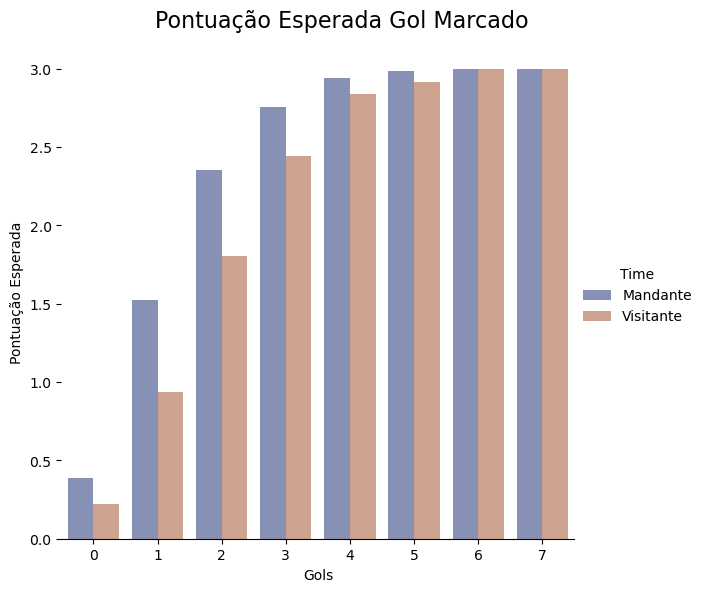

In [6]:
g = sns.catplot(
    data=df_pontuacao, 
    kind="bar",
    x="Gols_Marcados", 
    y="Pontuacao_Esperada", 
    hue="Time", 
    palette="dark", 
    alpha=.5, 
    height=6
)
g.despine(left=True)
g.fig.suptitle("Pontuação Esperada Gol Marcado", fontsize=16)
g.fig.subplots_adjust(top=0.92)
g.set_axis_labels("Gols", "Pontuação Esperada");

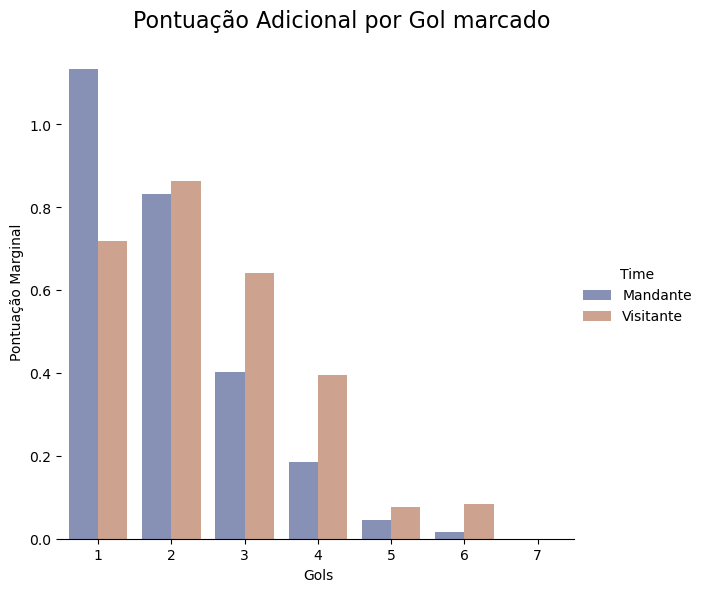

In [7]:
g = sns.catplot(
    data=df_pontuacao[df_pontuacao['Gols_Marcados'] != 0], 
    kind="bar",
    x="Gols_Marcados", 
    y="Pontuacao_Marginal", 
    hue="Time", 
    palette="dark", 
    alpha=.5, 
    height=6
)
g.despine(left=True)
g.fig.suptitle("Pontuação Adicional por Gol marcado", fontsize=16)
g.fig.subplots_adjust(top=0.92)
g.set_axis_labels("Gols", "Pontuação Marginal");

#### Chegamos à conclusão que os primeiros gols garantem uma quantidade marginal de pontos maior que gols posteriores. 
O quinto gol dificilmente será decisivo para garantir um resultado, enquanto o primeiro gol é muito decisivo.

## Passo 2: Encontrar a quantidade de gols de cada jogador discriminada pelo placar no momento do gol
Utilizando a métrica acima, vamos definir quais são os jogadores que marcam os gols mais decisivos.

Nessa etapa, criaremos um dataframe com os gols de cada jogador. Importante saber se o gol é em casa ou fora.

In [8]:
df_id_ano = pd.read_csv(path+"\\campeonato-brasileiro-full.csv", index_col="ID")
df_id_ano['Ano'] = df_id_ano['data'].str[6:10]
df_id_ano = df_id_ano[['Ano', 'mandante']].reset_index()

df_goleadores = pd.read_csv(path+"\\campeonato-brasileiro-gols.csv")
df_goleadores = pd.merge(df_goleadores, df_id_ano, left_on="partida_id", right_on="ID")
df_goleadores['Mandante/Visitante'] = df_goleadores.apply(lambda x: "Mandante" if x["clube"] == x["mandante"] else "Visitante", axis=1)
df_goleadores = df_goleadores.drop(['mandante', 'rodata', 'ID', 'clube', 'minuto'], axis=1) 
df_goleadores.rename(columns = {'atleta':'Atleta'}, inplace=True)

Gol_n = []
for i in df_goleadores.index:
    partida_id = df_goleadores.iloc[i]['partida_id']
    casa_fora = df_goleadores.iloc[i]['Mandante/Visitante']
    df_ref = df_goleadores.iloc[:i+1]
    df_ref = df_ref[((df_ref['Mandante/Visitante'] == casa_fora) & (df_ref['partida_id'] == partida_id))]
    Gol_n.append(df_ref.shape[0])

df_goleadores['Gol_n'] = Gol_n
df_goleadores = df_goleadores.groupby(['Ano','Atleta','Mandante/Visitante','Gol_n']).count().reset_index()
df_goleadores.rename(columns = {'partida_id':'Quantidade'}, inplace=True)
df_goleadores.head()

,Ano,Atleta,Mandante/Visitante,Gol_n,Quantidade,tipo_de_gol
0,2014,Abuda,Mandante,1,1,0
1,2014,Abuda,Visitante,1,1,0
2,2014,Ademilson,Mandante,2,1,0
3,2014,Alan Kardec,Mandante,1,2,0
4,2014,Alan Kardec,Mandante,2,1,0


Com o DataFrame criado, vamos cruzar com nossa tabela de pontuação esperada para definir os jogadores que marcam os gols mais decisivos. Vamos também filtrar também somente valores a partir do ano 2020.

In [9]:
cols_pontuacao = ['Gols_Marcados','Time','Pontuacao_Marginal']
cols_final = ['Ano', 'Atleta', 'Mandante/Visitante', 'Gol_n', 'Quantidade', 'Pontuacao_Marginal']
df_goleadores = pd.merge(df_goleadores, df_pontuacao[cols_pontuacao], 
         left_on = ['Gol_n', 'Mandante/Visitante'],
         right_on = ['Gols_Marcados', 'Time'])[cols_final]

cols_final = ['Ano','Atleta','Quantidade','Pontuacao_Marginal_Atleta']

df_goleadores['Pontuacao_Marginal_Atleta'] = df_goleadores['Quantidade'] * df_goleadores['Pontuacao_Marginal']
df_goleadores = df_goleadores.groupby(['Ano','Atleta']).sum().reset_index()[cols_final]
df_goleadores['Pontuacao_Marginal_Atleta'] = df_goleadores['Pontuacao_Marginal_Atleta'].round(decimals=2)
df_goleadores.rename(columns={"Quantidade":"Gols Marcados", "Pontuacao_Marginal_Atleta": "Pontos Conquistados"}, inplace=True)
df_goleadores = df_goleadores[df_goleadores['Ano'].astype(int) >= 2020]
df_goleadores_sorted = df_goleadores.sort_values(by='Pontos Conquistados', ascending=False)

# Vamos pegar a lista dos 5 maiores pontuadores
df_goleadores_sorted
#ultimo_ano_df = df_goleadores['Ano'].max()
#df_goleadores['UltimoAno'] = df_goleadores['Ano'] == ultimo_ano_df

,Ano,Atleta,Gols Marcados,Pontos Conquistados
2544,2022,Germán Cano,26,21.51
3009,2023,Paulinho,21,18.65
2685,2022,Pedro Raúl,19,16.94
2199,2021,Hulk,19,15.94
2181,2021,Gilberto Oliveira Souza Junior,17,15.25
...,...,...,...,...
2433,2021,Zé Gabriel,1,0.18
1977,2020,Mauricio Isla,1,0.18
2891,2023,Hércules,1,0.18
2932,2023,Kevyson,1,0.18


Finalmente, vamos criar o scatterplot destacando os 5 jogadores que mais pontuaram para seus times no ano desde 2020. 

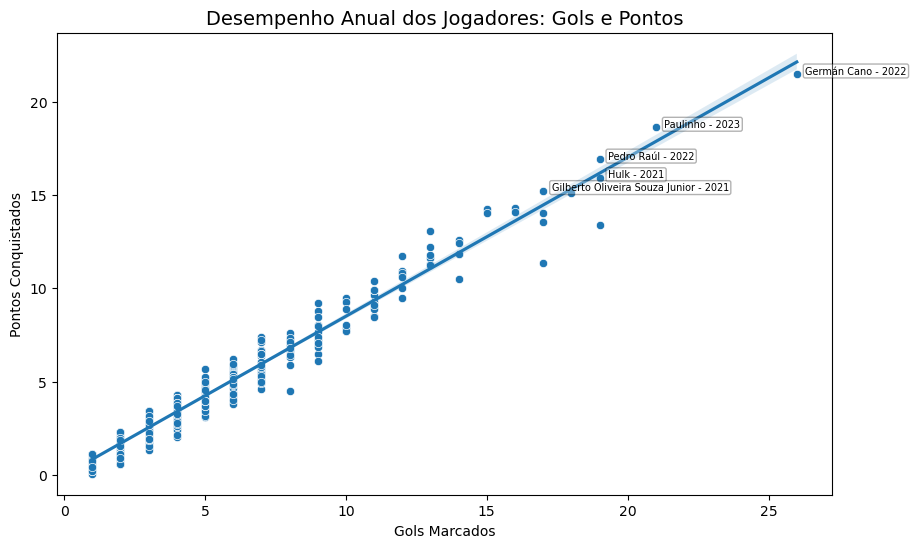

In [12]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_goleadores, x='Gols Marcados', y='Pontos Conquistados')

sns.regplot(data=df_goleadores, x='Gols Marcados', y='Pontos Conquistados', scatter=False)

for i in range(5):  # Only the top 5
    plt.text(x=df_goleadores_sorted.iloc[i]['Gols Marcados'] + 0.3,
             y=df_goleadores_sorted.iloc[i]['Pontos Conquistados'],
             s=df_goleadores_sorted.iloc[i]['Atleta']+ ' - ' +
                 df_goleadores_sorted.iloc[i]['Ano'],
             fontdict=dict(color='black', size=7),
             bbox=dict(facecolor='white', alpha=0.3, boxstyle='round,pad=0.2'))

plt.title("Desempenho Anual dos Jogadores: Gols e Pontos", fontsize=14)

plt.show()

## Conclusão:
#### Os atletas que retornaram a maior pontuação para seus clubes desde 2020 foram Germán Cano (2022), Paulinho (2023), Pedro Raúl (2022), Hulk (2021) e Gilberto (2021)